<h1>Libraries</h1>


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn_genetic import GASearchCV
from sklearn_genetic import ExponentialAdapter
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn_genetic.callbacks import ProgressBar, DeltaThreshold, ThresholdStopping, TensorBoard, LogbookSaver
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


<h1>Processing<h1>

In [17]:
# Random Seed at file level
random_seed = 40
np.random.seed(random_seed)

In [18]:
#data set loading
df = pd.read_csv('dlfeatures.csv')

In [24]:
df = df.fillna(0)

In [19]:
#Sampling

#---------------------------Undersampling----------------------------------------

df_majority = df[df.gender == 1]  # Assuming 1 represents females
df_minority = df[df.gender == 0]  # Assuming 0 represents males

# Downsample the majority class then combine
df_majority_downsampled = df_majority.sample(n = len(df_minority), random_state = random_seed)  # Ensure reproducibility with a random state
df_under_balanced = pd.concat([df_majority_downsampled, df_minority])
df_under_balanced = df_under_balanced.sample(frac=1, random_state= random_seed).reset_index(drop=True) # Shuffle the dataset to prevent any order bias

#----------------------------------------------------------------------------------





In [5]:
df_under_balanced = df_under_balanced.drop(columns=['filename'])

# Separate features and target label
features = df_under_balanced.drop('gender', axis=1)
target = df_under_balanced['gender']


In [20]:
#Preprocessing: Standardization
standard_scaler = StandardScaler() 

X = standard_scaler.fit_transform(features) 


<h1>Split<h1>

In [21]:
#Divide dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,target, test_size=0.2)

<h1>Feature Selection/Dimensionality Reduction<h1>

In [8]:
n_components = 25

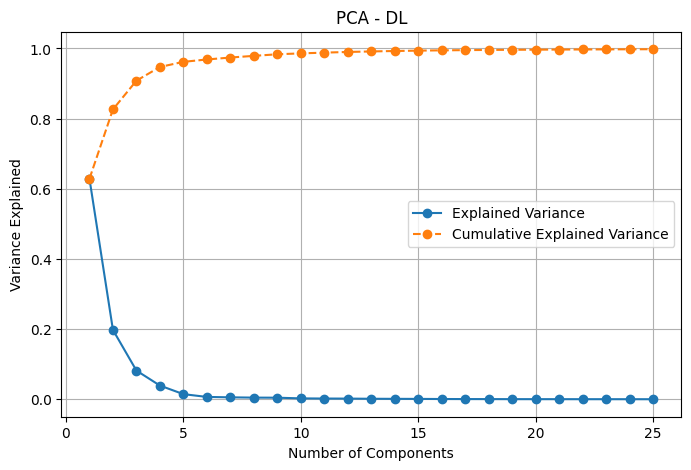

In [9]:

pca = PCA(n_components=n_components, random_state=random_seed)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Plot explained and cumulative variances
explained_variances = pca.explained_variance_ratio_
cumulative_variances = np.cumsum(explained_variances)

plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), explained_variances, marker='o', linestyle='-', label='Explained Variance')
plt.plot(range(1, n_components + 1), cumulative_variances, marker='o', linestyle='--', label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('PCA - DL')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Create directories for saving results
os.makedirs("./results", exist_ok=True)

<h1>Tuning<h1>

<h3>Decision Trees<h3>

In [10]:
from sklearn_genetic import GASearchCV
from sklearn.model_selection import StratifiedKFold
# Define the param_grid
param_grid = {
    'max_depth': Integer(2, 300, random_state=random_seed),
    'min_samples_split': Integer(2, 300, random_state=random_seed),
    'min_samples_leaf': Integer(2, 300, random_state=random_seed),
    'max_leaf_nodes': Integer(2, 300, random_state=random_seed),
}

mutation_adapter = ExponentialAdapter(initial_value=0.8, end_value=0.2, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.2, end_value=0.8, adaptive_rate=0.1)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)

clf = DecisionTreeClassifier(random_state=random_seed)

In [11]:
# Function to run GASearchCV and evaluate the model
def run_ga_search(X_train, y_train, X_test, y_test, case_name):
    # Ensure that inputs are numpy arrays if they are DataFrames
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(y_test, pd.Series):
        y_test = y_test.values

    callbacks = [
        ProgressBar(),
        DeltaThreshold(threshold=0.001, generations=10, metric='fitness_min'),
        ThresholdStopping(threshold=0.8, metric='fitness_min'),
    ]

    evolved_estimator = GASearchCV(
        estimator=clf,
        cv=cv,
        scoring='accuracy',
        population_size=50,
        generations=50,
        mutation_probability=mutation_adapter,
        crossover_probability=crossover_adapter,
        param_grid=param_grid,
        n_jobs=-1,
        keep_top_k=3
    )

    evolved_estimator.fit(X_train, y_train, callbacks=callbacks)


    print(f"Best parameters for {case_name}: ", evolved_estimator.best_params_)

    y_pred_ga = evolved_estimator.predict(X_test)

    print(f"Accuracy score for {case_name}: ", accuracy_score(y_test, y_pred_ga))
    print(f"F1 score (weighted) for {case_name}: ", f1_score(y_test, y_pred_ga, average='weighted'))

    classification_rep = classification_report(y_test, y_pred_ga, output_dict=True)


    # Save the classification report to a CSV
    df_classification_report = pd.DataFrame(classification_rep).transpose()
    df_classification_report.to_csv(f"results/classification_report_{case_name}.csv")

    # Save stats achieved in each generation to a CSV
    df_stats = pd.DataFrame(evolved_estimator.history)
    df_stats.to_csv(f"results/stats_{case_name}.csv", index=False)

    # Save the best k solutions to a CSV
    df_hof = pd.DataFrame(evolved_estimator.hof)
    df_hof.to_csv(f"results/best_k_solutions_{case_name}.csv", index=False)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_ga)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {case_name}')
    plt.tight_layout()
    os.makedirs('results', exist_ok=True)
    plt.savefig(f'results/confusion_matrix_ga_dt_{case_name}.png')
    plt.show()

    # Plot Fitness Evolution
    plt.figure(figsize=(10, 8))
    plot_fitness_evolution(evolved_estimator)
    plt.title('Fitness Evolution')
    plt.savefig(f'results/fitness_evolution_{case_name}.png')
    plt.show()


    # Plot Search Space
    plt.figure(figsize=(10, 8))
    plot_search_space(evolved_estimator)
    plt.title('Search Space Visualization')
    plt.savefig(f'results/search_space_{case_name}.png')
    plt.show()

    # Save metadata for further analysis
    print(f"Stats achieved in each generation for {case_name}: ", evolved_estimator.history)
    print(f"Best k solutions for {case_name}: ", evolved_estimator.hof)

    # Save stats and best k solutions to files
    with open(f'results/stats_{case_name}.txt', 'w') as f:
        f.write(f"Stats achieved in each generation for {case_name}:\n")
        f.write(str(evolved_estimator.history))
    with open(f'results/best_k_solutions_{case_name}.txt', 'w') as f:
        f.write(f"Best k solutions for {case_name}:\n")
        f.write(str(evolved_estimator.hof))
    

  0%|          | 0/51 [00:00<?, ?it/s]gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.714982	0.00947547 	0.730825   	0.694117   
 55%|█████▍    | 28/51 [04:45<04:16, 11.15s/it]INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm
 55%|█████▍    | 28/51 [04:45<03:54, 10.21s/it]
Best parameters for PCA:  {'max_depth': 65, 'min_samples_split': 65, 'min_samples_leaf': 59, 'max_leaf_nodes': 97}
Accuracy score for PCA:  0.68
F1 score (weighted) for PCA:  0.6783844741673225


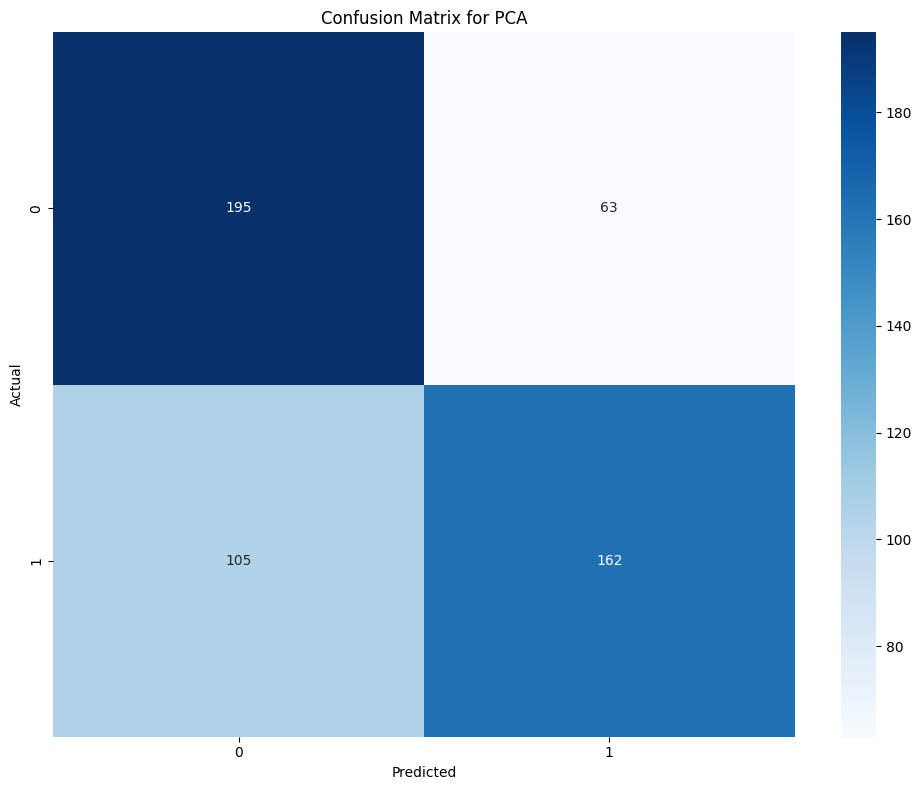

c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


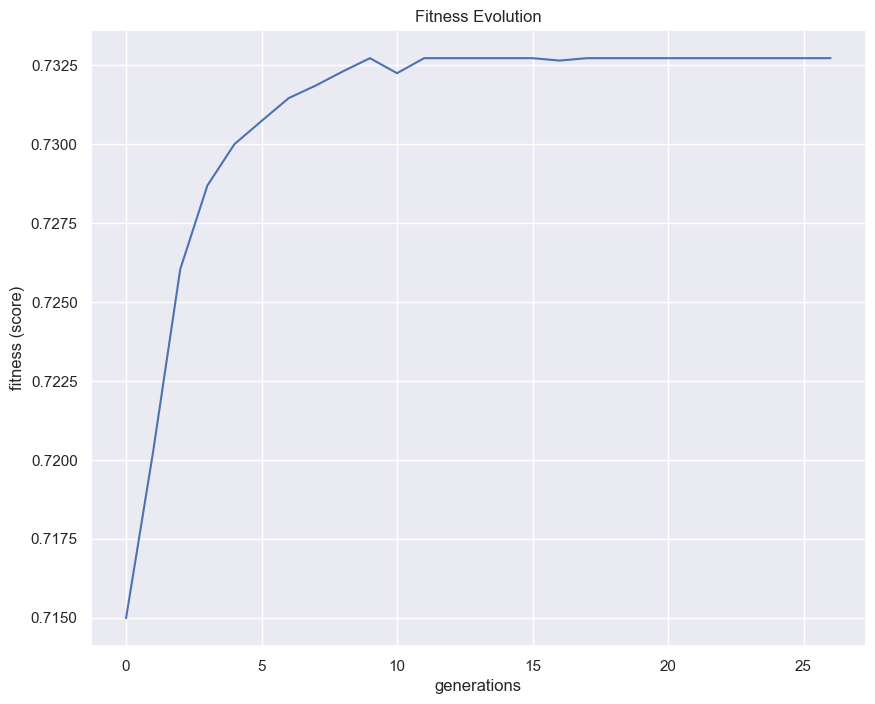

c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fil

<Figure size 1000x800 with 0 Axes>

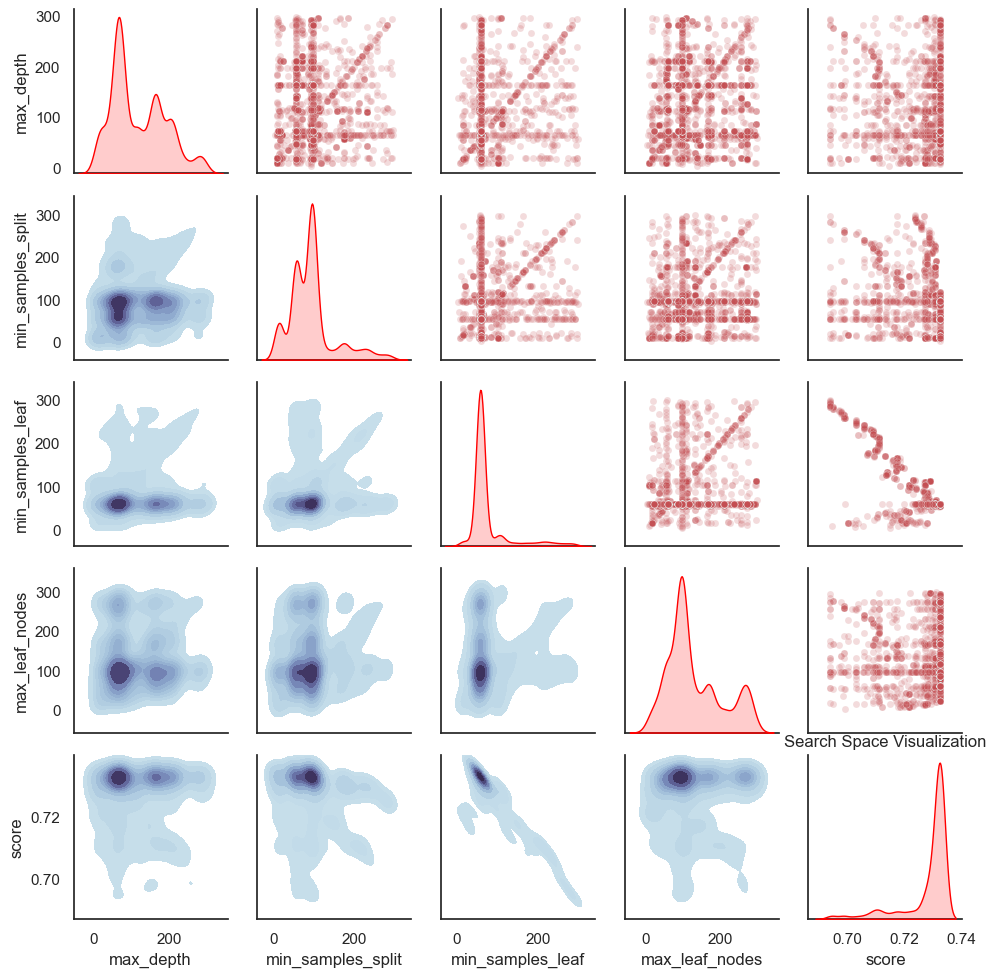

Stats achieved in each generation for PCA:  {'gen': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], 'fitness': [0.7149823650034175, 0.7202640692640692, 0.7260413761676919, 0.7286917293233084, 0.7300053770790613, 0.7307385281385282, 0.731462428799271, 0.7318624287992711, 0.7323103212576899, 0.7327295055821373, 0.7322530416951472, 0.732729551150604, 0.732729551150604, 0.732729551150604, 0.732729551150604, 0.732729551150604, 0.7326533606744136, 0.732729551150604, 0.732729551150604, 0.732729551150604, 0.732729551150604, 0.732729551150604, 0.732729551150604, 0.732729551150604, 0.732729551150604, 0.732729551150604, 0.732729551150604], 'fitness_std': [0.009475469284677103, 0.007009923444846848, 0.004498459551869033, 0.0018075702879600374, 0.0011663434642245893, 0.000945798307670158, 0.0009209417554451814, 0.000940897483617812, 0.0007889440114655658, 3.189792663560453e-07, 0.0033352407143975816, 1.1102230246251565e-16, 1.1102230246251565e-16,

In [12]:
run_ga_search(X_train_pca, y_train, X_test_pca, y_test, 'PCA')

<h3>Naive Bayes<h3>

In [35]:
from sklearn_genetic import GASearchCV, space
from sklearn.model_selection import StratifiedKFold
# Define the param_grid
param_grid = {
    'var_smoothing': space.Continuous(1e-10, 1e-8, random_state=random_seed)
}

mutation_adapter = ExponentialAdapter(initial_value=0.8, end_value=0.2, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.2, end_value=0.8, adaptive_rate=0.1)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)

clf = GaussianNB()

In [36]:
# Function to run GASearchCV and evaluate the model
def run_ga_search(X_train, y_train, X_test, y_test, case_name):
    # Ensure that inputs are numpy arrays if they are DataFrames
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(y_test, pd.Series):
        y_test = y_test.values

    callbacks = [
        ProgressBar(),
        DeltaThreshold(threshold=0.001, generations=10, metric='fitness_min'),
        ThresholdStopping(threshold=0.8, metric='fitness_min'),
    ]

    evolved_estimator = GASearchCV(
        estimator=clf,
        cv=cv,
        scoring='accuracy',
        population_size=50,
        generations=50,
        mutation_probability=mutation_adapter,
        crossover_probability=crossover_adapter,
        param_grid=param_grid,
        n_jobs=-1,
        keep_top_k=3
    )

    evolved_estimator.fit(X_train, y_train, callbacks=callbacks)


    print(f"Best parameters for {case_name}: ", evolved_estimator.best_params_)

    y_pred_ga = evolved_estimator.predict(X_test)

    print(f"Accuracy score for {case_name}: ", accuracy_score(y_test, y_pred_ga))
    print(f"F1 score (weighted) for {case_name}: ", f1_score(y_test, y_pred_ga, average='weighted'))

    classification_rep = classification_report(y_test, y_pred_ga, output_dict=True)


    # Save the classification report to a CSV
    df_classification_report = pd.DataFrame(classification_rep).transpose()
    df_classification_report.to_csv(f"results/classification_report_{case_name}.csv")

    # Save stats achieved in each generation to a CSV
    df_stats = pd.DataFrame(evolved_estimator.history)
    df_stats.to_csv(f"results/stats_{case_name}.csv", index=False)

    # Save the best k solutions to a CSV
    df_hof = pd.DataFrame(evolved_estimator.hof)
    df_hof.to_csv(f"results/best_k_solutions_{case_name}.csv", index=False)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_ga)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {case_name}')
    plt.tight_layout()
    os.makedirs('results', exist_ok=True)
    plt.savefig(f'results/confusion_matrix_ga_dt_{case_name}.png')
    plt.show()

    # Plot Fitness Evolution
    plt.figure(figsize=(10, 8))
    plot_fitness_evolution(evolved_estimator)
    plt.title('Fitness Evolution')
    plt.savefig(f'results/fitness_evolution_{case_name}.png')
    plt.show()


    # Plot Search Space
    plt.figure(figsize=(10, 8))
    plot_search_space(evolved_estimator)
    plt.title('Search Space Visualization')
    plt.savefig(f'results/search_space_{case_name}.png')
    plt.show()

    # Save metadata for further analysis
    print(f"Stats achieved in each generation for {case_name}: ", evolved_estimator.history)
    print(f"Best k solutions for {case_name}: ", evolved_estimator.hof)

    # Save stats and best k solutions to files
    with open(f'results/stats_{case_name}.txt', 'w') as f:
        f.write(f"Stats achieved in each generation for {case_name}:\n")
        f.write(str(evolved_estimator.history))
    with open(f'results/best_k_solutions_{case_name}.txt', 'w') as f:
        f.write(f"Best k solutions for {case_name}:\n")
        f.write(str(evolved_estimator.hof))
    

c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn_genetic\genetic_search.py:279: UserWarning: Warning, only one parameter was provided to the param_grid, the optimization routine might not have effect or it could lead to errors, it's advised to use at least 2 parameters
  warnings.warn(


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.701285	2.22045e-16	0.701285   	0.701285   
1  	100   	0.701285	2.22045e-16	0.701285   	0.701285   
2  	100   	0.701285	2.22045e-16	0.701285   	0.701285   
3  	100   	0.701285	2.22045e-16	0.701285   	0.701285   
4  	100   	0.701285	2.22045e-16	0.701285   	0.701285   
5  	100   	0.701285	2.22045e-16	0.701285   	0.701285   
6  	100   	0.701285	2.22045e-16	0.701285   	0.701285   
7  	100   	0.701285	2.22045e-16	0.701285   	0.701285   
8  	100   	0.701285	2.22045e-16	0.701285   	0.701285   
9  	100   	0.701285	2.22045e-16	0.701285   	0.701285   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm
 22%|██▏       | 11/51 [00:29<01:46,  2.65s/it]
Best parameters for PCA:  {'var_smoothing': 7.325995103120705e-09}
Accuracy score for PCA:  0.7085714285714285
F1 score (weighted) for PCA:  0.707400106394785


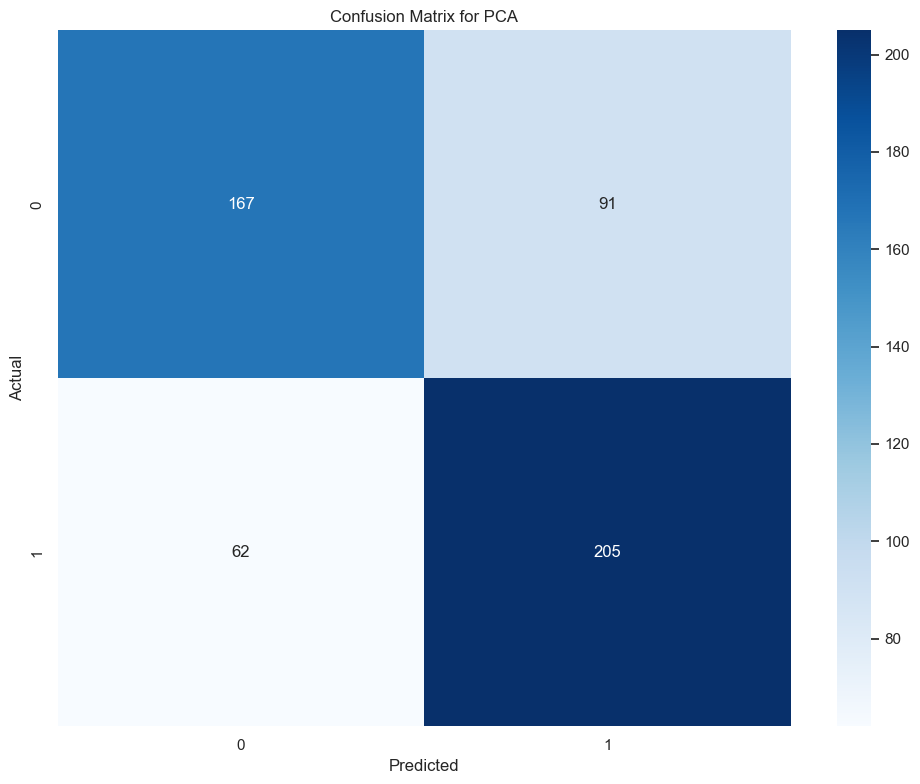

c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


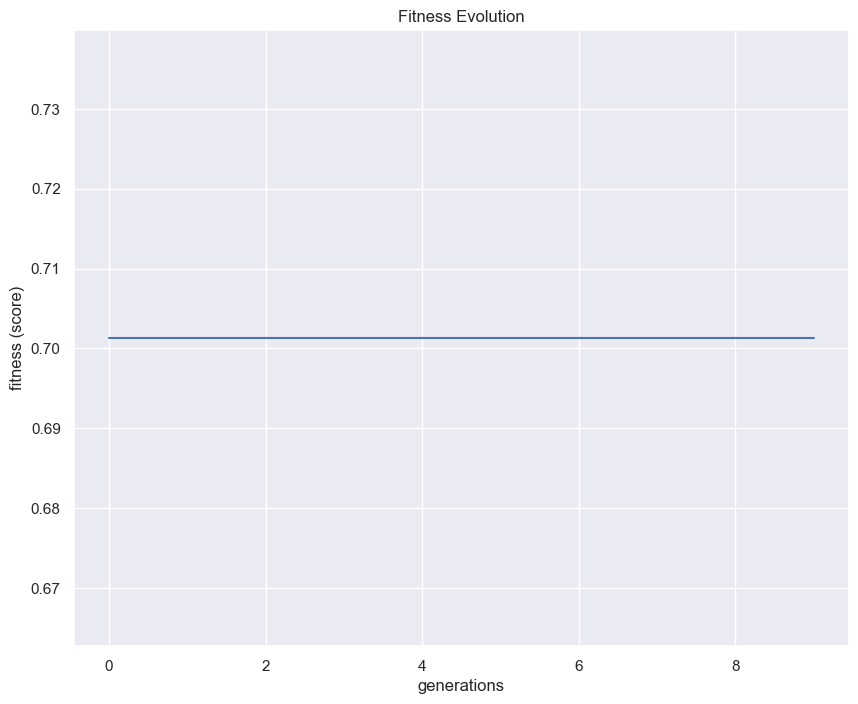

c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0

<Figure size 1000x800 with 0 Axes>

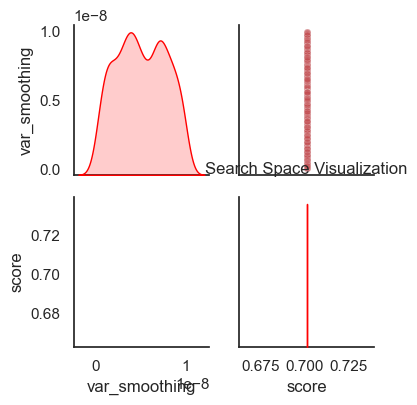

Stats achieved in each generation for PCA:  {'gen': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'fitness': [0.7012850307587147, 0.7012850307587147, 0.7012850307587147, 0.7012850307587147, 0.7012850307587147, 0.7012850307587147, 0.7012850307587147, 0.7012850307587147, 0.7012850307587147, 0.7012850307587147], 'fitness_std': [2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16], 'fitness_max': [0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715], 'fitness_min': [0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715, 0.701285030758715]}
Best k solutions for PCA:  {0: {'var_smoot

In [37]:
run_ga_search(X_train_pca, y_train, X_test_pca, y_test, 'PCA')

<h3>KNN<h3>

In [38]:
from sklearn_genetic import GASearchCV
from sklearn.model_selection import StratifiedKFold
# Define the param_grid
param_grid = {
    'n_neighbors': Integer(1, 200),
    'metric': Categorical(['euclidean', 'manhattan', 'minkowski']),
    'weights': Categorical(['uniform', 'distance'])
}

mutation_adapter = ExponentialAdapter(initial_value=0.8, end_value=0.2, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.2, end_value=0.8, adaptive_rate=0.1)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)

clf = KNeighborsClassifier()

In [39]:
# Function to run GASearchCV and evaluate the model
def run_ga_search(X_train, y_train, X_test, y_test, case_name):
    # Ensure that inputs are numpy arrays if they are DataFrames
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(y_test, pd.Series):
        y_test = y_test.values

    callbacks = [
        ProgressBar(),
        DeltaThreshold(threshold=0.001, generations=10, metric='fitness_min'),
        ThresholdStopping(threshold=0.85, metric='fitness_min'),
    ]

    evolved_estimator = GASearchCV(
        estimator=clf,
        cv=cv,
        scoring='accuracy',
        population_size=50,
        generations=50,
        mutation_probability=mutation_adapter,
        crossover_probability=crossover_adapter,
        param_grid=param_grid,
        n_jobs=-1,
        keep_top_k=3
    )

    evolved_estimator.fit(X_train, y_train, callbacks=callbacks)


    print(f"Best parameters for {case_name}: ", evolved_estimator.best_params_)

    y_pred_ga = evolved_estimator.predict(X_test)

    print(f"Accuracy score for {case_name}: ", accuracy_score(y_test, y_pred_ga))
    print(f"F1 score (weighted) for {case_name}: ", f1_score(y_test, y_pred_ga, average='weighted'))

    classification_rep = classification_report(y_test, y_pred_ga, output_dict=True)


    # Save the classification report to a CSV
    df_classification_report = pd.DataFrame(classification_rep).transpose()
    df_classification_report.to_csv(f"results/classification_report_{case_name}.csv")

    # Save stats achieved in each generation to a CSV
    df_stats = pd.DataFrame(evolved_estimator.history)
    df_stats.to_csv(f"results/stats_{case_name}.csv", index=False)

    # Save the best k solutions to a CSV
    df_hof = pd.DataFrame(evolved_estimator.hof)
    df_hof.to_csv(f"results/best_k_solutions_{case_name}.csv", index=False)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_ga)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {case_name}')
    plt.tight_layout()
    os.makedirs('results', exist_ok=True)
    plt.savefig(f'results/confusion_matrix_ga_dt_{case_name}.png')
    plt.show()

    # Plot Fitness Evolution
    plt.figure(figsize=(10, 8))
    plot_fitness_evolution(evolved_estimator)
    plt.title('Fitness Evolution')
    plt.savefig(f'results/fitness_evolution_{case_name}.png')
    plt.show()


    # Plot Search Space
    plt.figure(figsize=(10, 8))
    plot_search_space(evolved_estimator)
    plt.title('Search Space Visualization')
    plt.savefig(f'results/search_space_{case_name}.png')
    plt.show()

    # Save metadata for further analysis
    print(f"Stats achieved in each generation for {case_name}: ", evolved_estimator.history)
    print(f"Best k solutions for {case_name}: ", evolved_estimator.hof)

    # Save stats and best k solutions to files
    with open(f'results/stats_{case_name}.txt', 'w') as f:
        f.write(f"Stats achieved in each generation for {case_name}:\n")
        f.write(str(evolved_estimator.history))
    with open(f'results/best_k_solutions_{case_name}.txt', 'w') as f:
        f.write(f"Best k solutions for {case_name}:\n")
        f.write(str(evolved_estimator.hof))
    

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.720713	0.0101123  	0.731287   	0.669836   
1  	100   	0.725678	0.00258266 	0.731287   	0.719852   
2  	100   	0.727203	0.00130941 	0.731287   	0.724147   
3  	100   	0.727918	0.00136298 	0.731287   	0.724625   
4  	100   	0.728718	0.0015933  	0.731287   	0.724625   
5  	100   	0.729994	0.00128408 	0.731287   	0.726528   
6  	100   	0.730612	0.00118883 	0.731287   	0.725575   
7  	100   	0.731021	0.00099084 	0.731287   	0.725566   
8  	100   	0.731287	0          	0.731287   	0.731287   
9  	100   	0.731287	0          	0.731287   	0.731287   
10 	100   	0.731297	6.73046e-05	0.731768   	0.731287   
11 	100   	0.731202	0.000811228	0.731768   	0.72558    
12 	100   	0.731307	9.42069e-05	0.731768   	0.731287   
13 	100   	0.731269	0.000426525	0.731768   	0.728426   
14 	100   	0.731383	0.000192299	0.731768   	0.731287   
15 	100   	0.731489	0.000237277	0.731768   	0.731287   
16 	100   	0.731633	0.000215855	0.731768   	0.73

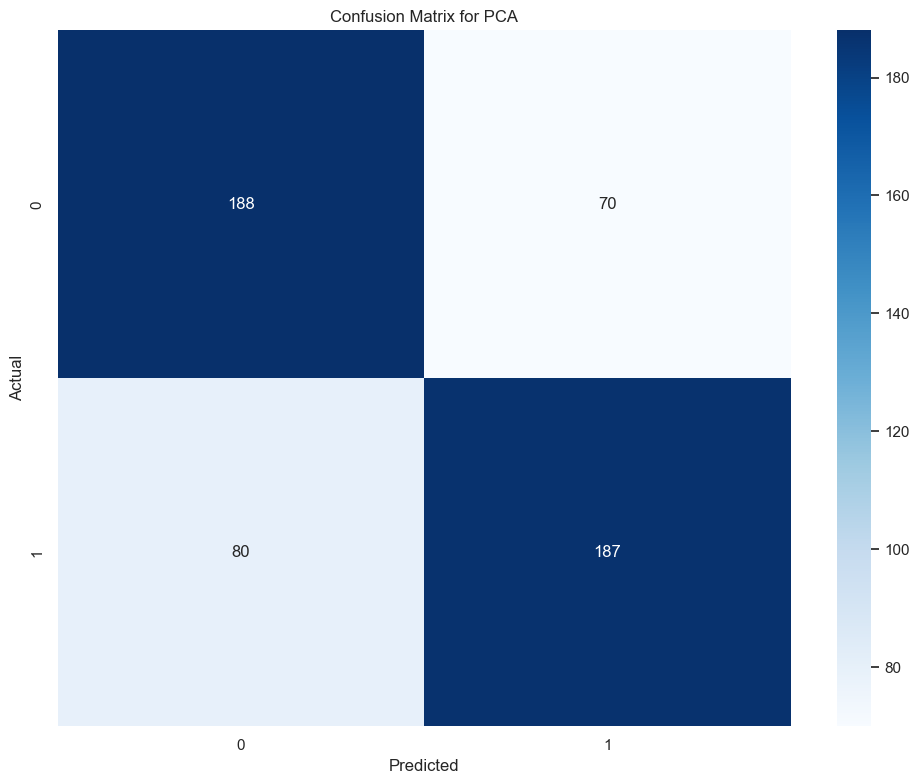

c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


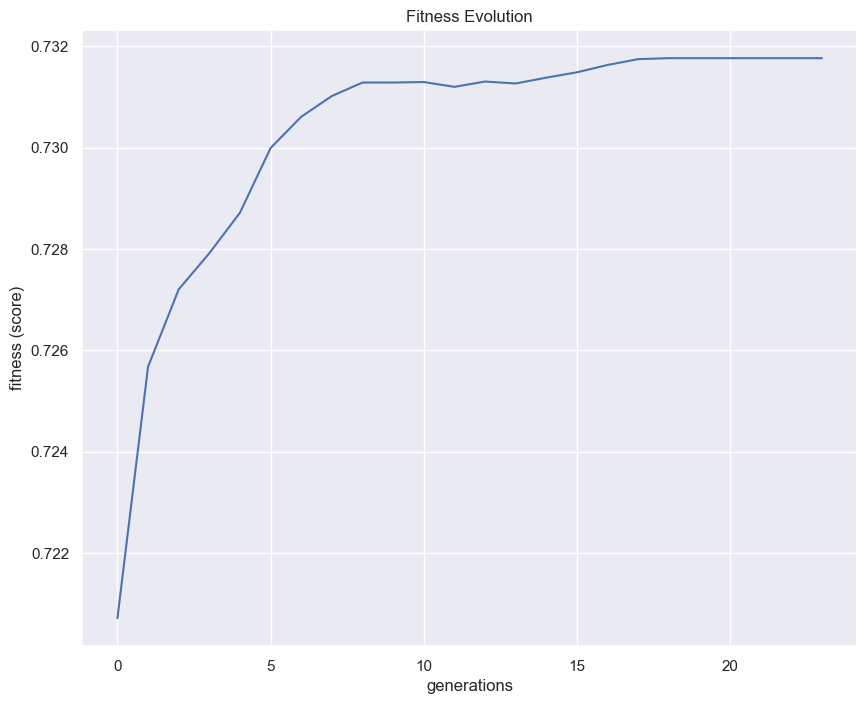

c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1615: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0

<Figure size 1000x800 with 0 Axes>

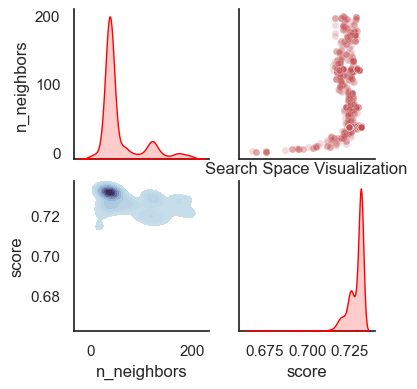

Stats achieved in each generation for PCA:  {'gen': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'fitness': [0.7207130097972204, 0.7256776942355891, 0.7272031897926635, 0.7279176577808159, 0.7287175210754158, 0.7299937115516063, 0.7306120300751878, 0.731020688083846, 0.731287309182046, 0.731287309182046, 0.7312969241285029, 0.7312020050125312, 0.73130653907496, 0.7312685349737982, 0.7313834586466165, 0.7314892230576439, 0.7316334472544997, 0.7317488266119844, 0.7317680565048984, 0.7317680565048984, 0.7317680565048984, 0.7317680565048984, 0.7317680565048984, 0.7317680565048984], 'fitness_std': [0.010112321703003541, 0.0025826557668556043, 0.0013094113940901263, 0.0013629776248347705, 0.001593304262825552, 0.0012840777949509534, 0.0011888348244037947, 0.0009908397039905255, 0.0, 0.0, 6.730462519935366e-05, 0.0008112275201509772, 9.420685089581884e-05, 0.00042652487861107843, 0.00019229892914101045, 0.00023727693099312574, 0.00021585501260675411,

In [40]:
run_ga_search(X_train_pca, y_train, X_test_pca, y_test, 'PCA')

<h1>Decision Trees<h1>

In [13]:
#best_DT_param = {'max_depth': 183, 'min_samples_split': 220, 'min_samples_leaf': 196, 'min_weight_fraction_leaf': 0.33669132339512997, 'max_leaf_nodes': 94, 'min_impurity_decrease': 0.007364375014116076, 'ccp_alpha': 0.0070839769194125605}
best_DT_param = {'max_depth': 65, 'min_samples_split': 65, 'min_samples_leaf': 59, 'max_leaf_nodes': 97}

Accuracy: 0.68
F1 Score: 0.6783844741673225
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       258
           1       0.72      0.61      0.66       267

    accuracy                           0.68       525
   macro avg       0.69      0.68      0.68       525
weighted avg       0.69      0.68      0.68       525

Classification report saved to results\classification_report.csv


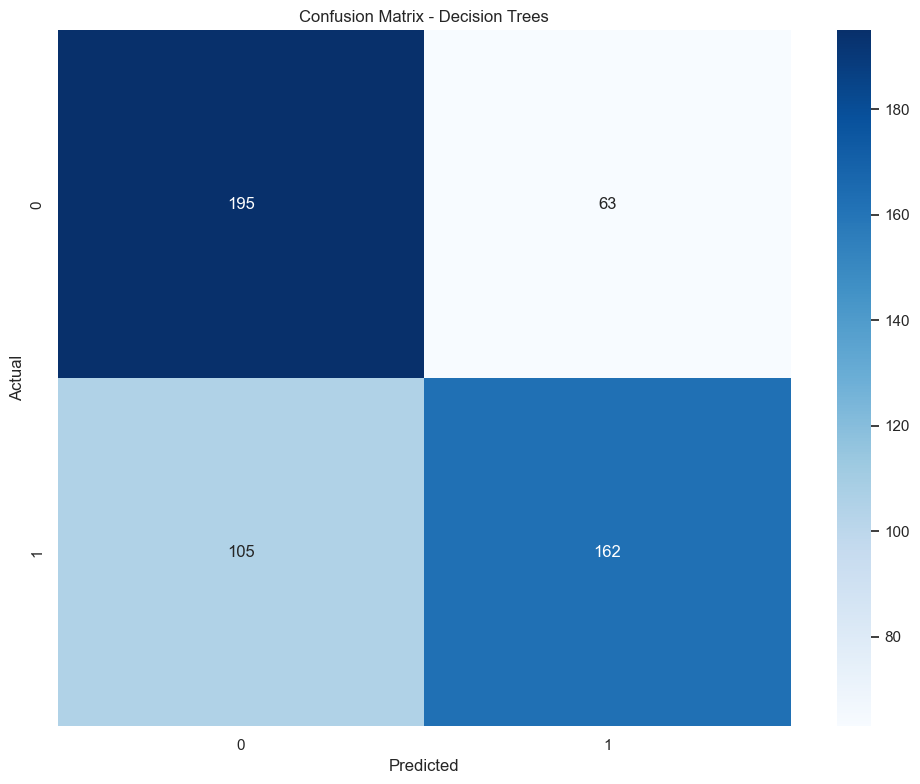

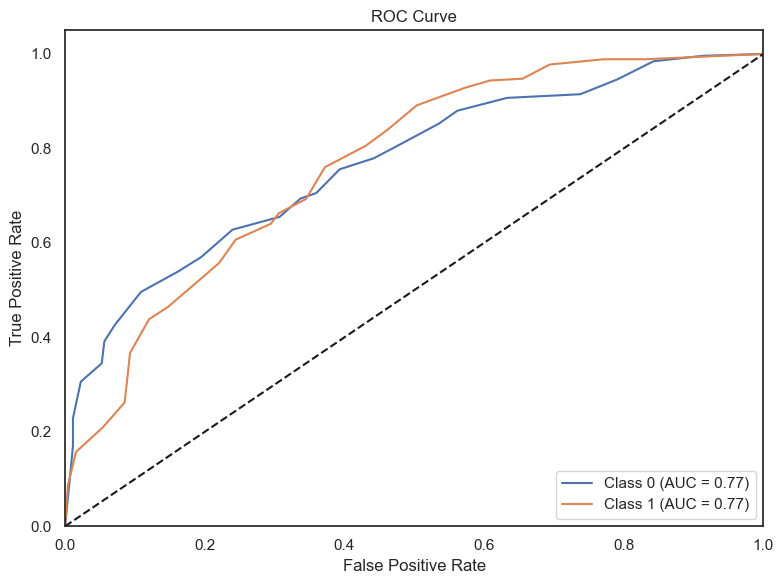

In [14]:
from sklearn.metrics import roc_curve, auc

clf = DecisionTreeClassifier(**best_DT_param, random_state = random_seed) 
clf.fit(X_train_pca,y_train)
y_pred = clf.predict(X_test_pca)


# Calculate the scores
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred))

# Save the classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

classification_report_save_path = os.path.join('results', 'classification_report.csv')
report_df.to_csv(classification_report_save_path, index=True)
print(f"Classification report saved to {classification_report_save_path}")

# Plot and save the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Trees')
plt.tight_layout()
plt.savefig(f'results/confusion_matrix.png')
plt.show()

# Initialize variables for ROC curves and AUC scores
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and AUC score for each class
classes = np.unique(y_test)
for j in range(len(classes)):
    fpr[j], tpr[j], _ = roc_curve(y_test, clf.predict_proba(X_test_pca)[:, j], pos_label=classes[j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for j in range(len(classes)):
    plt.plot(fpr[j], tpr[j], label=f'Class {classes[j]} (AUC = {roc_auc[j]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


[Text(0.5, 0.75, 'x[0] <= -3.597\ngini = 0.5\nsamples = 2099\nvalue = [1054, 1045]'),
 Text(0.25, 0.25, 'gini = 0.347\nsamples = 818\nvalue = [183, 635]'),
 Text(0.75, 0.25, 'gini = 0.435\nsamples = 1281\nvalue = [871, 410]')]

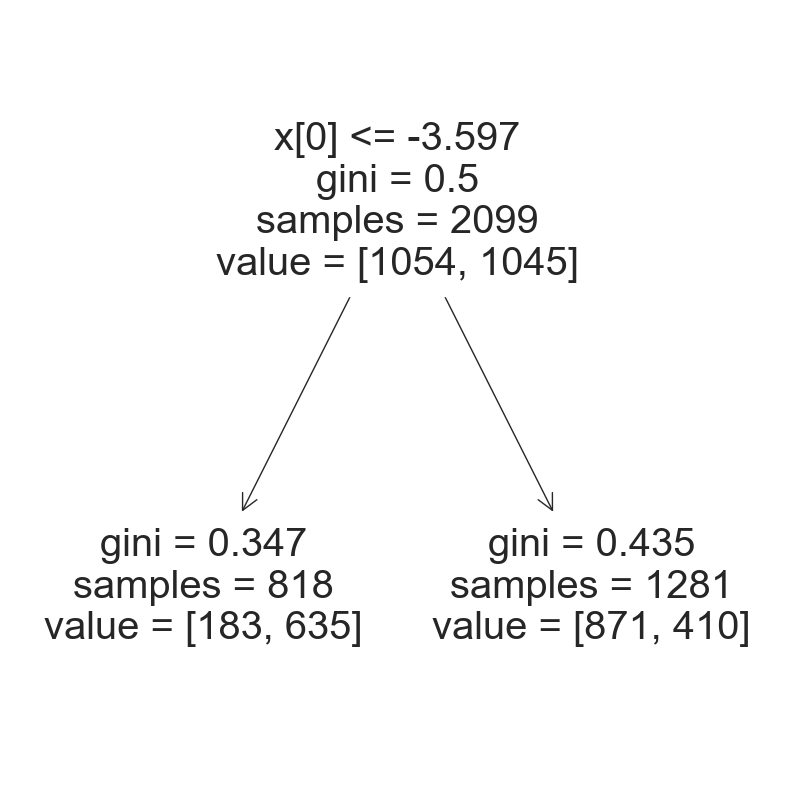

In [54]:
from sklearn import tree

tree.plot_tree(clf)


<h1>Naive Bayes<h1>

Accuracy: 0.7066666666666667
F1 Score: 0.7039442406456345
              precision    recall  f1-score   support

           0       0.75      0.61      0.67       258
           1       0.68      0.80      0.73       267

    accuracy                           0.71       525
   macro avg       0.71      0.71      0.70       525
weighted avg       0.71      0.71      0.70       525

Classification report saved to results\classification_report.csv


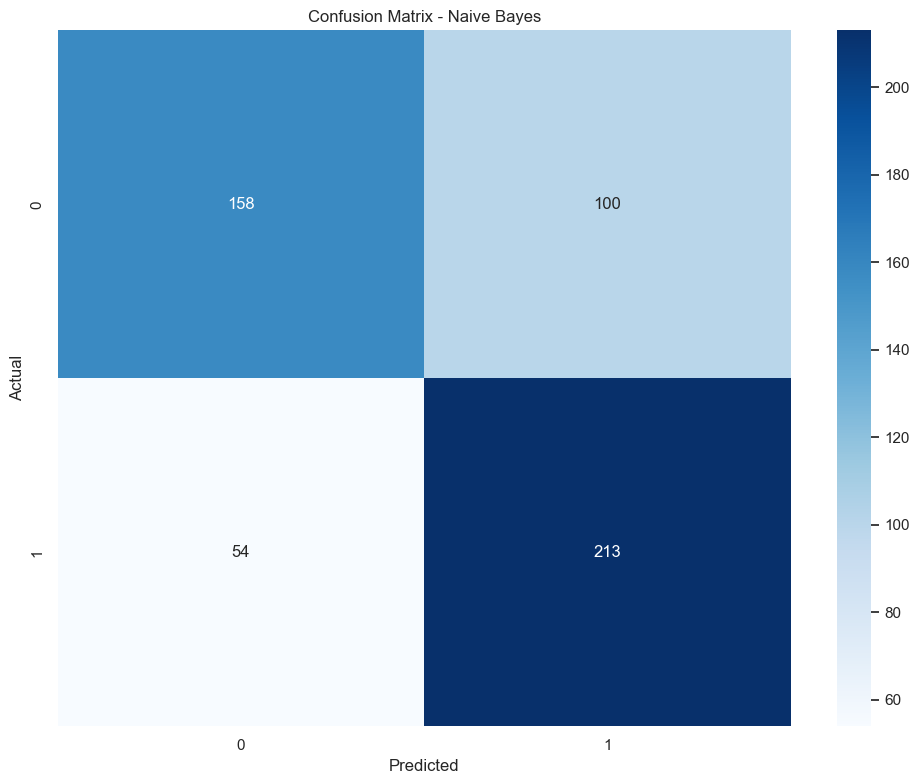

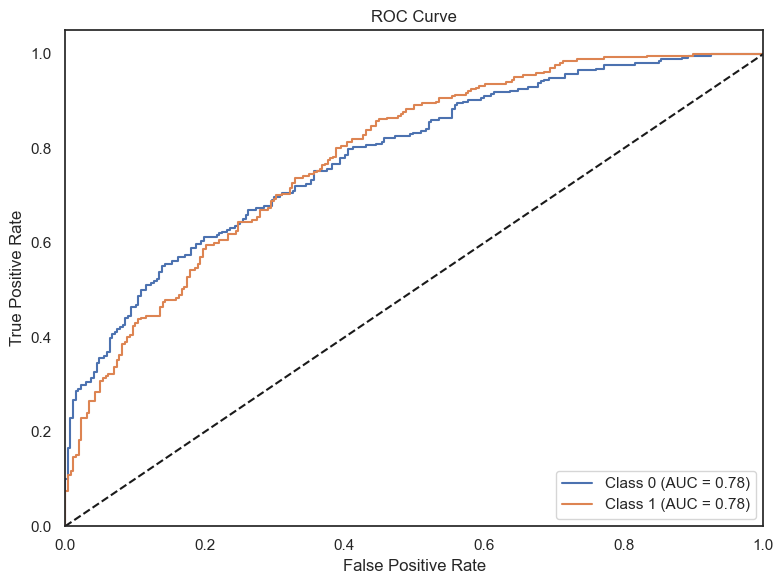

In [60]:
clf = GaussianNB(var_smoothing =0.38881) 
clf.fit(X_train_pca,y_train)
y_pred_nb = clf.predict(X_test_pca)


# Calculate the scores
accuracy = accuracy_score(y_test, y_pred_nb)
f1 = f1_score(y_test, y_pred_nb, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred_nb))

# Save the classification report
report = classification_report(y_test, y_pred_nb, output_dict=True)
report_df = pd.DataFrame(report).transpose()

classification_report_save_path = os.path.join('results', 'classification_report.csv')
report_df.to_csv(classification_report_save_path, index=True)
print(f"Classification report saved to {classification_report_save_path}")

# Plot and save the confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.tight_layout()
plt.savefig(f'results/confusion_matrix.png')
plt.show()

# Initialize variables for ROC curves and AUC scores
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and AUC score for each class
classes = np.unique(y_test)
for j in range(len(classes)):
    fpr[j], tpr[j], _ = roc_curve(y_test, clf.predict_proba(X_test_pca)[:, j], pos_label=classes[j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for j in range(len(classes)):
    plt.plot(fpr[j], tpr[j], label=f'Class {classes[j]} (AUC = {roc_auc[j]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


<h1>KNN<h1>

In [55]:
best_KKN_param ={'n_neighbors': 37, 'leaf_size': 37, 'p': 2}

Accuracy: 0.7142857142857143
F1 Score: 0.7142753481969225
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       258
           1       0.73      0.70      0.71       267

    accuracy                           0.71       525
   macro avg       0.71      0.71      0.71       525
weighted avg       0.71      0.71      0.71       525

Classification report saved to results\classification_report.csv


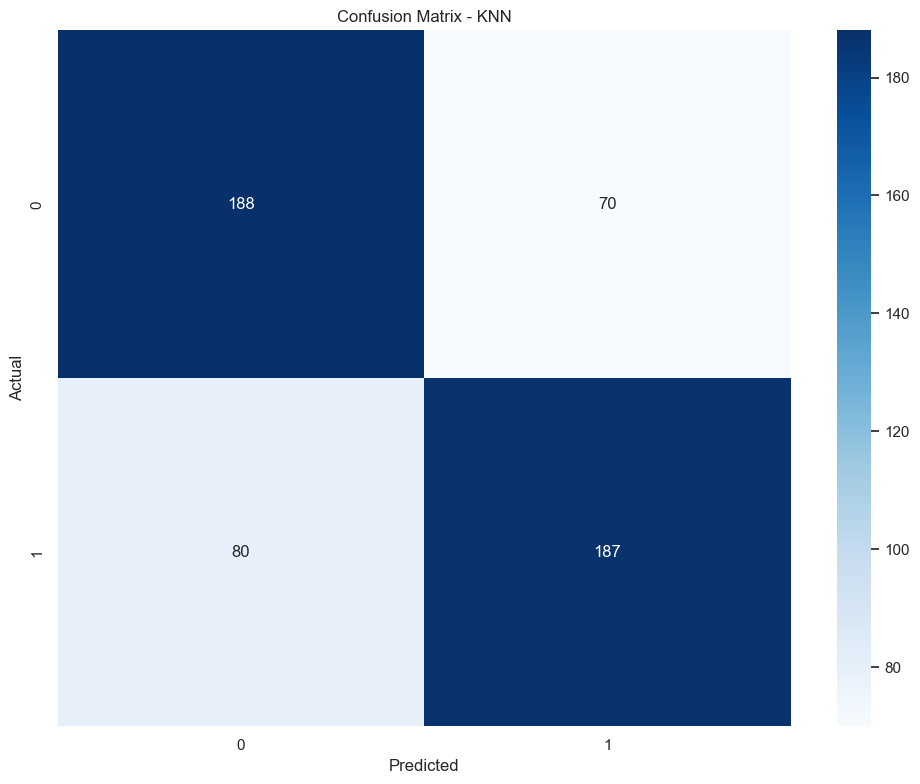

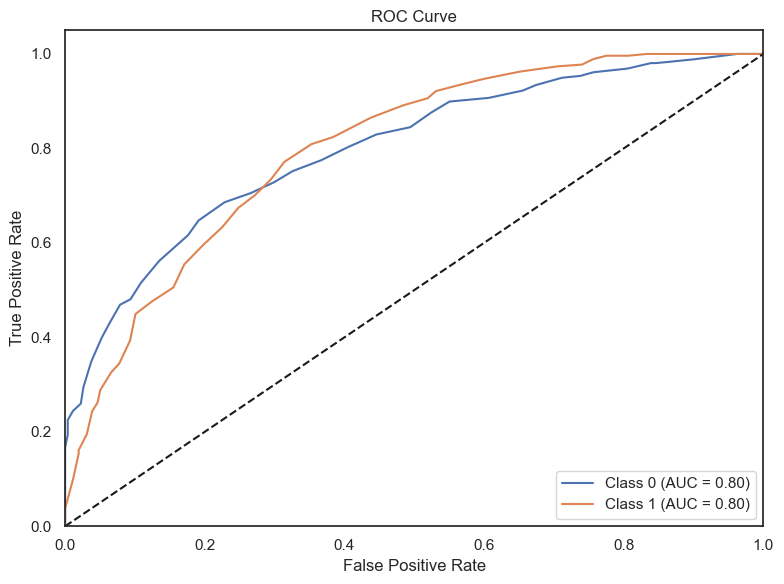

In [57]:
clf = KNeighborsClassifier(**best_KKN_param) 
clf.fit(X_train_pca,y_train)
y_pred_nb = clf.predict(X_test_pca)

# Calculate the scores
accuracy = accuracy_score(y_test, y_pred_nb)
f1 = f1_score(y_test, y_pred_nb, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred_nb))

# Save the classification report
report = classification_report(y_test, y_pred_nb, output_dict=True)
report_df = pd.DataFrame(report).transpose()

classification_report_save_path = os.path.join('results', 'classification_report.csv')
report_df.to_csv(classification_report_save_path, index=True)
print(f"Classification report saved to {classification_report_save_path}")

# Plot and save the confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.tight_layout()
plt.savefig(f'results/confusion_matrix.png')
plt.show()

# Initialize variables for ROC curves and AUC scores
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and AUC score for each class
classes = np.unique(y_test)
for j in range(len(classes)):
    fpr[j], tpr[j], _ = roc_curve(y_test, clf.predict_proba(X_test_pca)[:, j], pos_label=classes[j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for j in range(len(classes)):
    plt.plot(fpr[j], tpr[j], label=f'Class {classes[j]} (AUC = {roc_auc[j]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

<h1>SVM<h1>

In [45]:
"""#hyperparameter Tuning

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Define the model
svm = SVC()

# Set up the parameter grid. You can adjust the ranges and values based on your computational capacity and dataset.
param_grid = {
    'C': [0.1, 1, 10, 100],  # Example values
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Example values
    'degree': [2, 3, 4],  # Only used for 'poly' kernel
    'coef0': [0, 0.5, 1]  # Only used for 'poly' and 'sigmoid'
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)  # n_jobs=-1 to use all available cores

# Fit GridSearchCV on your training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# Evaluate on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

# Optionally, save the best model or further analyze the results
"""

'#hyperparameter Tuning\n\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.svm import SVC\nfrom sklearn.metrics import classification_report\n\n# Define the model\nsvm = SVC()\n\n# Set up the parameter grid. You can adjust the ranges and values based on your computational capacity and dataset.\nparam_grid = {\n    \'C\': [0.1, 1, 10, 100],  # Example values\n    \'kernel\': [\'linear\', \'rbf\', \'poly\', \'sigmoid\'],\n    \'gamma\': [\'scale\', \'auto\', 0.01, 0.1, 1],  # Example values\n    \'degree\': [2, 3, 4],  # Only used for \'poly\' kernel\n    \'coef0\': [0, 0.5, 1]  # Only used for \'poly\' and \'sigmoid\'\n}\n\n# Set up GridSearchCV with cross-validation\ngrid_search = GridSearchCV(svm, param_grid, cv=5, scoring=\'accuracy\', verbose=2, n_jobs=-1)  # n_jobs=-1 to use all available cores\n\n# Fit GridSearchCV on your training data\ngrid_search.fit(X_train, y_train)\n\n# Print the best parameters and the corresponding score\nprint("Best parameters found: ", gri

c:\Users\Yo200\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.7257142857142858
F1 Score: 0.7255530254955391
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       258
           1       0.75      0.70      0.72       267

    accuracy                           0.73       525
   macro avg       0.73      0.73      0.73       525
weighted avg       0.73      0.73      0.73       525

Classification report saved to results\classification_report.csv


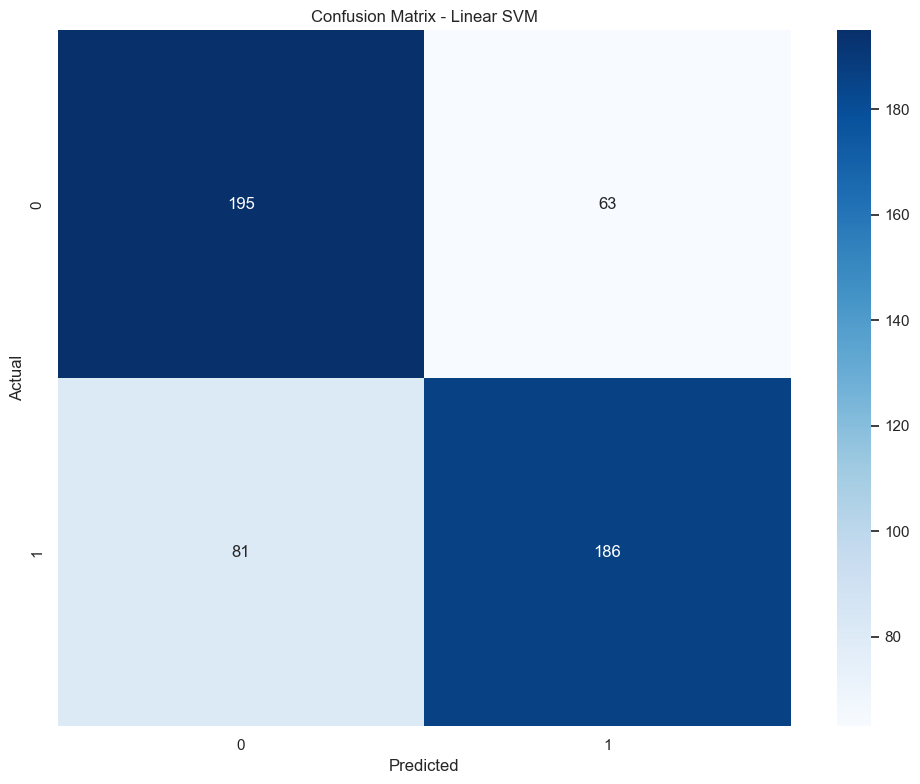

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [22]:
clf = LinearSVC(C= 0.43286,penalty= 'l1', random_state= random_seed, dual = False) 
#clf = SVC(kernel='linear', C=1, gamma=1);
#clf = SVC(C = 2,gamma = 0.1 ,kernel='linear', random_state= random_seed)
clf.fit(X_train,y_train)
y_pred_nb = clf.predict(X_test)


# Calculate the scores
accuracy = accuracy_score(y_test, y_pred_nb)
f1 = f1_score(y_test, y_pred_nb, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred_nb))

# Save the classification report
report = classification_report(y_test, y_pred_nb, output_dict=True)
report_df = pd.DataFrame(report).transpose()

classification_report_save_path = os.path.join('results', 'classification_report.csv')
report_df.to_csv(classification_report_save_path, index=True)
print(f"Classification report saved to {classification_report_save_path}")

# Plot and save the confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Linear SVM')
plt.tight_layout()
plt.savefig(f'results/confusion_matrix.png')
plt.show()

# Initialize variables for ROC curves and AUC scores
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and AUC score for each class
classes = np.unique(y_test)
for j in range(len(classes)):
    fpr[j], tpr[j], _ = roc_curve(y_test, clf.predict_proba(X_test_pca)[:, j], pos_label=classes[j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for j in range(len(classes)):
    plt.plot(fpr[j], tpr[j], label=f'Class {classes[j]} (AUC = {roc_auc[j]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [23]:
clf = XGBClassifier(random_state=random_seed)

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       258
           1       0.71      0.69      0.70       267

    accuracy                           0.70       525
   macro avg       0.70      0.70      0.70       525
weighted avg       0.70      0.70      0.70       525

